# Proyek Klasifikasi Gambar: [food11]
- **Nama:** Nurulita Prihartini
- **Email:** nurul.lita19109@gmail.com
- **ID Dicoding:** nurulita09

## Import Semua Packages/Library yang Digunakan

In [69]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [70]:
import os, shutil
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import keras
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

#### Fetching Data from Kaggle

In [3]:
# Import module provided by google colab for file upload needs
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nurulita09","key":"384c613175a50297ee4ed8c507870837"}'}

In [4]:
# Download kaggle dataset and unzip the file
!kaggle datasets download -d imbikramsaha/food11
!unzip food11.zip

Streaming output truncated to the last 5000 lines.
  inflating: food11/train/hamburger/2722745.jpg  
  inflating: food11/train/hamburger/272642.jpg  
  inflating: food11/train/hamburger/2726558.jpg  
  inflating: food11/train/hamburger/2738245.jpg  
  inflating: food11/train/hamburger/2745577.jpg  
  inflating: food11/train/hamburger/2745917.jpg  
  inflating: food11/train/hamburger/2754513.jpg  
  inflating: food11/train/hamburger/2756964.jpg  
  inflating: food11/train/hamburger/2762170.jpg  
  inflating: food11/train/hamburger/2766731.jpg  
  inflating: food11/train/hamburger/2771605.jpg  
  inflating: food11/train/hamburger/277584.jpg  
  inflating: food11/train/hamburger/2777938.jpg  
  inflating: food11/train/hamburger/2790429.jpg  
  inflating: food11/train/hamburger/279510.jpg  
  inflating: food11/train/hamburger/2797268.jpg  
  inflating: food11/train/hamburger/279729.jpg  
  inflating: food11/train/hamburger/2808308.jpg  
  inflating: food11/train/hamburger/281725.jpg  
  in

### Combine Train Data and Test Data to the Same Directory

In [5]:
# Initial directory for train and test
train_dir = "food11/train"
test_dir = "food11/test"

# New directory for combined dataset
all_dir = "food11/dataset"

In [6]:
# Create a new directory for the combined dataset
os.makedirs(all_dir, exist_ok=True)

In [7]:
# Copy files and folders from train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(all_dir, category), dirs_exist_ok=True)

# Copy files and folders from test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(all_dir, category), dirs_exist_ok=True)

### Sample images for all classes

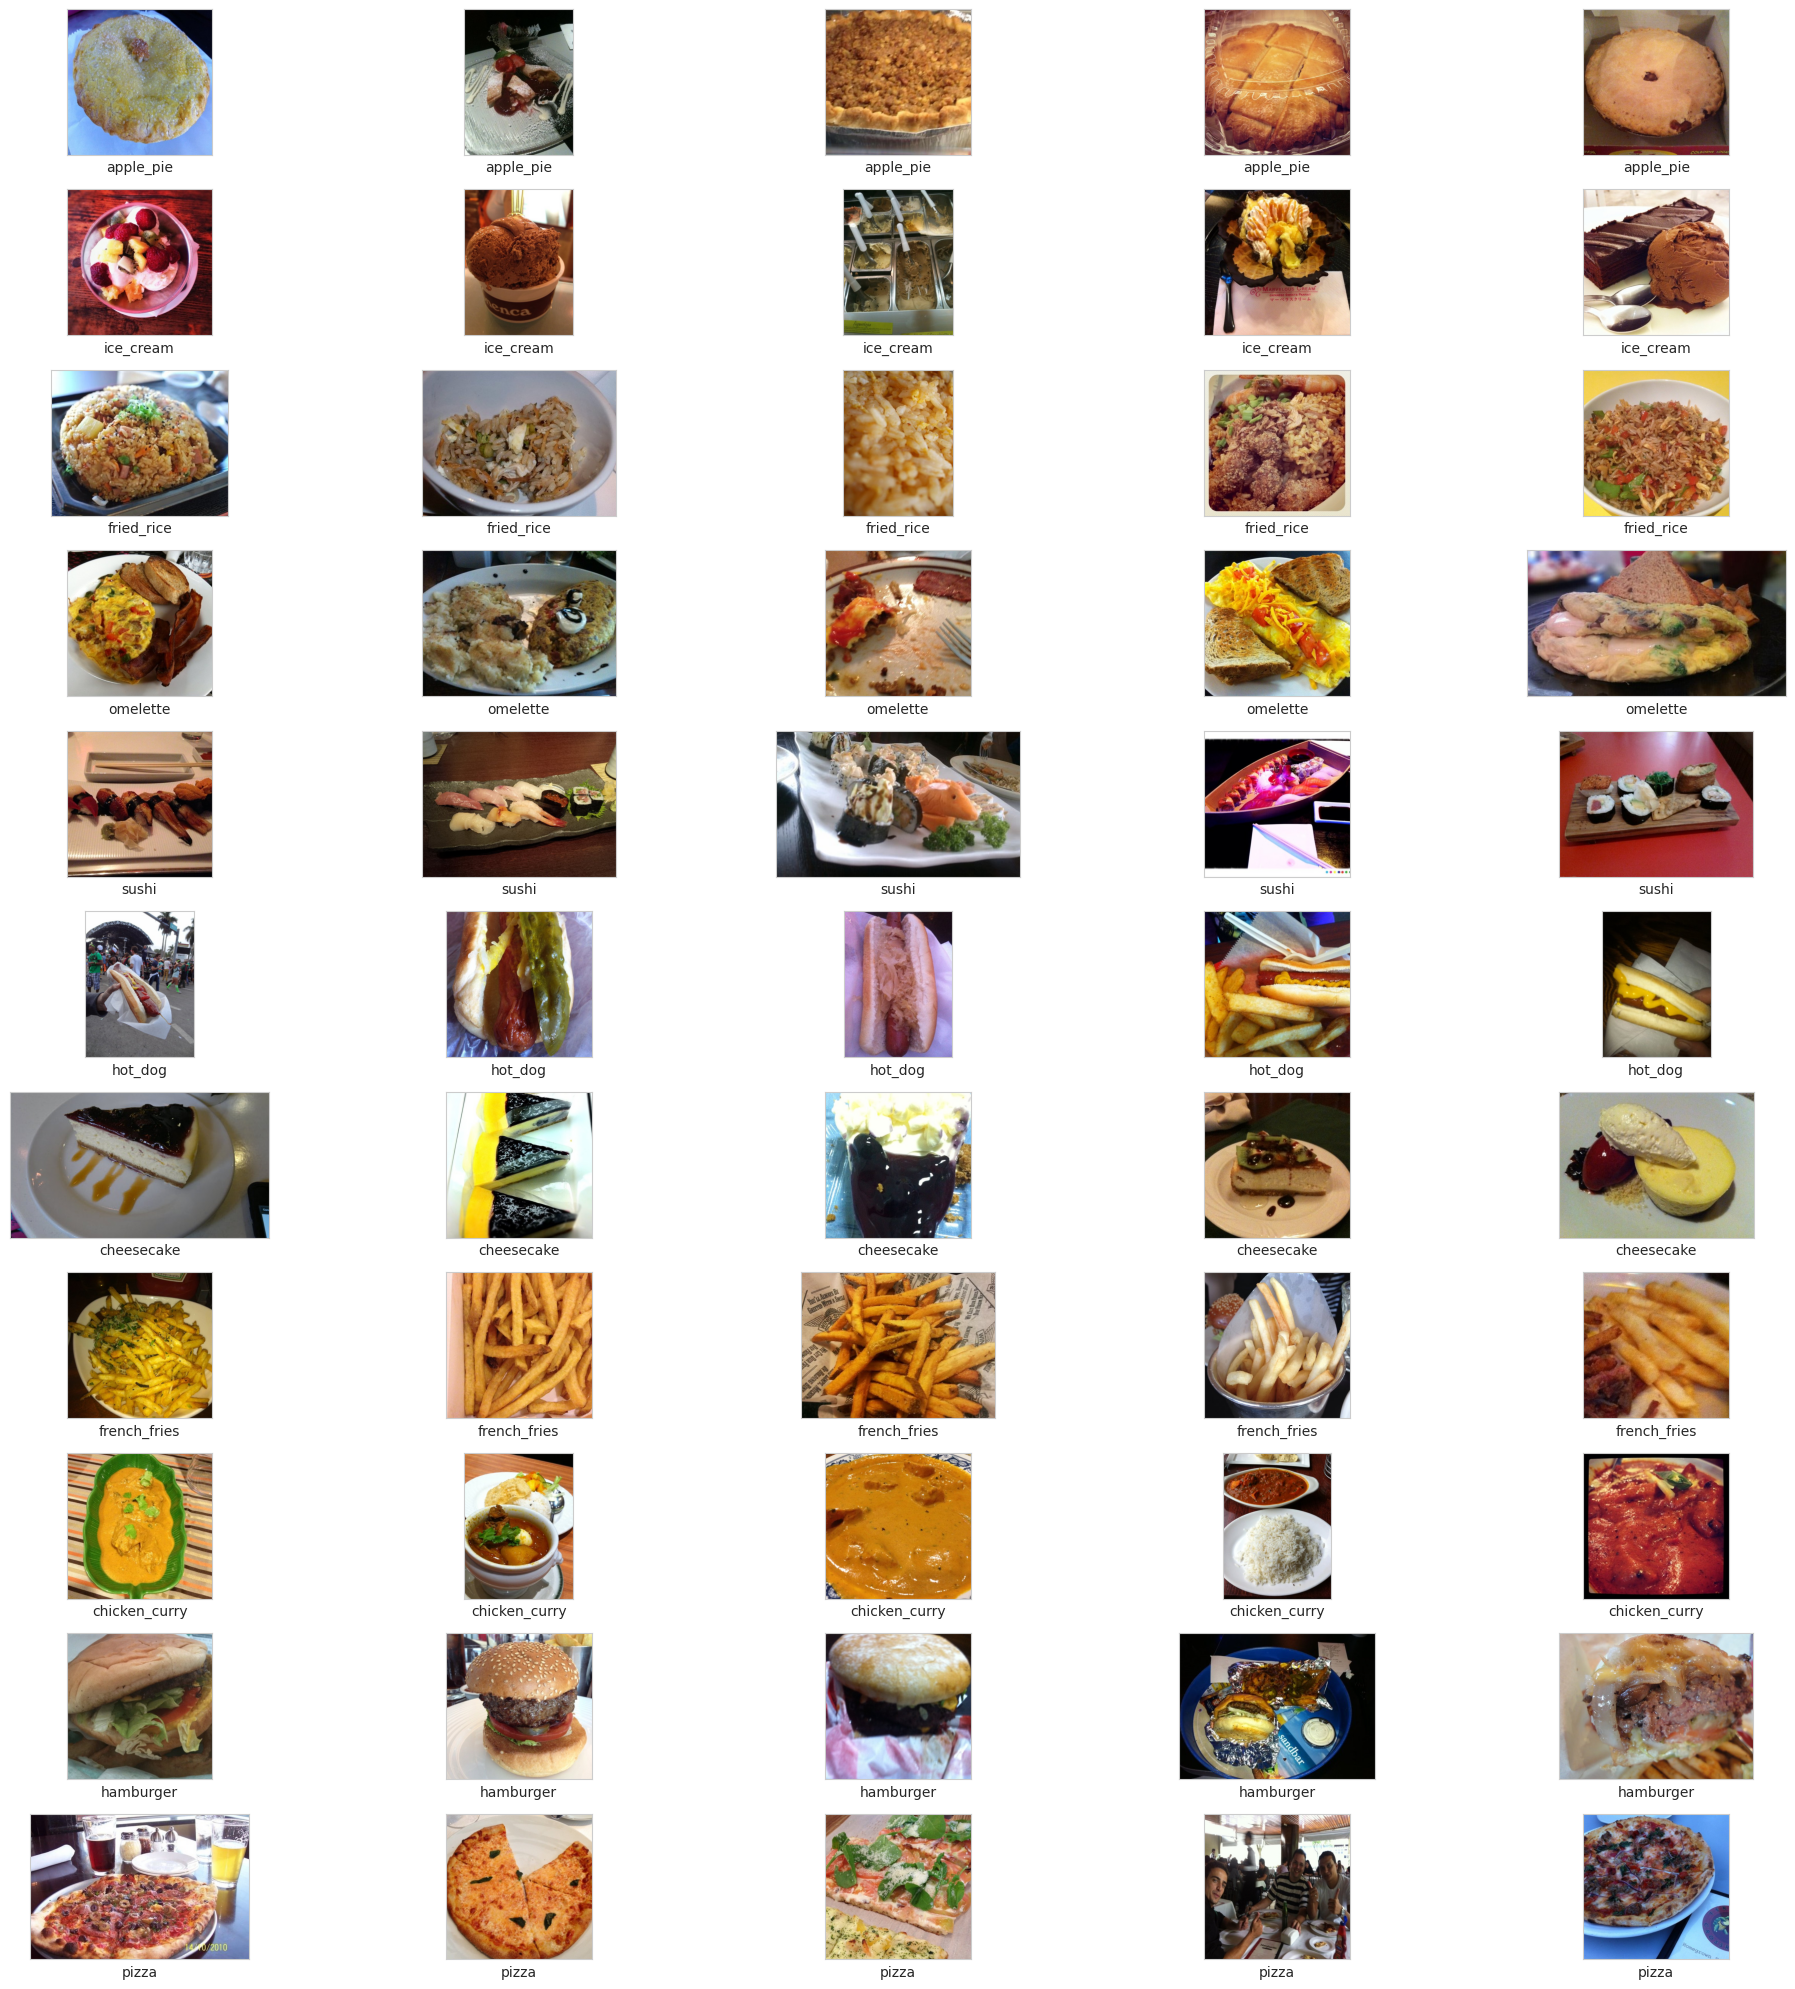

In [83]:
# Create a dictionary that stores an image for each class in the data
images_dict = {}

# Define the train source path
path = "food11/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  images_dict[i] = os.listdir(os.path.join(path_sub, i))

# Randomly display 5 images under each of the 15 classes of data.
# See a different image each time this code is run.
path_sub = "food11/dataset/"

# Randomly display 5 images under each class from the training data
fig, axs = plt.subplots(len(images_dict.keys()), 5, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(images_dict[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path)
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

### Distribution Plot

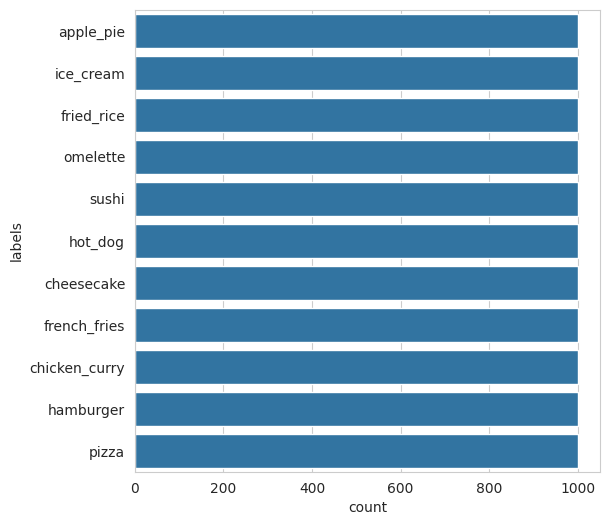

In [9]:
# Define the source path
imgs_path = "food11/dataset/"

# Create a list that stores data for each file name, file path, and label in the data
file_name = []
labels = []
full_path = []

# Get the image file name, file path, and label one by one by looping, and save it as a dataframe
for path, subdir, files in os.walk(imgs_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Image distribution plots in each class
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("whitegrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [29]:
mypath = 'food11/dataset/'

file_name = []
labels = []
full_path = []

for path, subdir, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

# Create dataframe
food_df = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
food_df.groupby(['labels']).size()

labels
apple_pie        1000
cheesecake       1000
chicken_curry    1000
french_fries     1000
fried_rice       1000
hamburger        1000
hot_dog          1000
ice_cream        1000
omelette         1000
pizza            1000
sushi            1000
dtype: int64

In [41]:
# Variables used in this data separation where variables x = path data and y = labels data
X = food_df['path']
y = food_df['labels']

# Split the initial dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [42]:
df_train = pd.DataFrame({'path':X_train, 'labels':y_train, 'set':'train'})
df_test = pd.DataFrame({'path':X_test, 'labels':y_test, 'set':'test'})

In [43]:
print('train size:', len(df_train))
print('test size:', len(df_test))

train size: 8800
test size: 2200


In [44]:
# Merge DataFrame df_train and df_test
all_df = pd.concat([df_train, df_test], ignore_index=True)

print(all_df.groupby(['set', 'labels']).size(), '\n')
print('=================================================== \n')

# Check sample data
print(all_df.sample(5))

set    labels       
test   apple_pie        220
       cheesecake       216
       chicken_curry    207
       french_fries     187
       fried_rice       188
       hamburger        214
       hot_dog          203
       ice_cream        178
       omelette         166
       pizza            214
       sushi            207
train  apple_pie        780
       cheesecake       784
       chicken_curry    793
       french_fries     813
       fried_rice       812
       hamburger        786
       hot_dog          797
       ice_cream        822
       omelette         834
       pizza            786
       sushi            793
dtype: int64 


                                       path      labels    set
1770       food11/dataset/sushi/1267200.jpg       sushi  train
3075  food11/dataset/fried_rice/3734919.jpg  fried_rice  train
816     food11/dataset/apple_pie/157083.jpg   apple_pie  train
4532   food11/dataset/fried_rice/862508.jpg  fried_rice  train
622    food11/dataset/ice_cream/

In [45]:
# The original dataset that contains all the image data that corresponds to the labels
dataog_path = "food11/dataset/"
# Create a Dataset variable, which will hold data that has been divided into training and testing data.
dataset_path = "Dataset-Final/"

In [46]:
for index, row in tq(all_df.iterrows()):
  # filepath detection
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(dataog_path, row['labels'], row['image'].split('.')[0])

  # Create a folder destination directory
  if os.path.exists(os.path.join(dataset_path,row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path,row['set'], row['labels']))

  # Specify the destination of the file
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path,row['set'], row['labels'], destination_file_name)

  # Copy file from source to destination
  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [47]:
# Define training and test directories
train_dir = "Dataset-Final/train/"
test_dir = "Dataset-Final/test/"

In [48]:
# Create an ImageDataGenerator object normalizing the images
dataGen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = dataGen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_gen = dataGen.flow_from_directory(train_dir,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_gen = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 8460 images belonging to 11 classes.
Found 2109 images belonging to 11 classes.
Found 3969 images belonging to 11 classes.


## Modelling

## Evaluasi dan Visualisasi

In [55]:
# Model initialization
model = Sequential()

# Add pre-trained InceptionV3 as base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Disable training on the base model (for transfer learning)
base_model.trainable = False

# Add InceptionV3 base model to Sequential model
model.add(base_model)

# Adding additional layers with different activation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.3))  # Leaky ReLU on convolutional layers
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(32, (4, 4), padding='same'))
model.add(LeakyReLU(alpha=0.3))  # Leaky ReLU on convolutional layers
model.add(BatchNormalization())

model.add(Conv2D(32, (7, 7), padding='same'))
model.add(LeakyReLU(alpha=0.3))  # Leaky ReLU on convolutional layers
model.add(BatchNormalization())

# Flatten layer before Dense
model.add(Flatten())

# First dense layer with ELU activation
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.3))  # Dropout for regularization

# Second dense layer with Swish activation
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output layer with 11 neurons (softmax for multi-class classification)
model.add(Dense(11, activation='softmax'))

# Building a model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_482 (Conv2D)                  │ (None, 3, 3, 32)            │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_482              │ (None, 3, 3, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_483 (Conv2D)                  │ (None, 1, 1, 32)            │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_483              │ (None, 1, 1, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_484 (Conv2D)                  │ (None, 1, 1, 32)            │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_484              │ (None, 1, 1, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,472,843 (85.73 MB)

 Trainable params: 669,867 (2.56 MB)

 Non-trainable params: 21,802,976 (83.17 MB)

In [56]:
# List of folders for each class
class_names = os.listdir(train_dir)

# Calculating the number of samples for each class
class_counts = {}
for class_name in class_names:
    class_counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))

# Total number of samples
total_samples = sum(class_counts.values())

# Calculating class_weight for each class
class_weights = {idx: (1 / count) * (total_samples) / len(class_counts)
for idx, (class_name, count) in enumerate(class_counts.items())}

%time

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True,
                               verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Fitting / training model with class_weight
history = model.fit(
    train_gen,
    epochs=30,
    batch_size=32,
    validation_data=validation_gen,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.4677 - loss: 1.6041 - val_accuracy: 0.6245 - val_loss: 1.3797 - learning_rate: 0.0010
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.6975 - loss: 0.9579 - val_accuracy: 0.6510 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.7732 - loss: 0.7293 - val_accuracy: 0.6643 - val_loss: 1.1023 - learning_rate: 0.0010
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8069 - loss: 0.6342 - val_accuracy: 0.6046 - val_loss: 1.2982 - learning_rate: 0.0010
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.8458 - loss: 0.4896
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
265/265 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.8457 - loss: 0.4897 - val_accuracy: 0.6633 - val_loss: 1.1668 - learning_rate: 0.0010
Epoch 6/30
265/26

In the training process:

* At the 5th epoch, the learning rate was decreased by using ReduceLROnPlateau to help the model find a better minimum point.

* At the 14th epoch, the model stopped early because there was no decrease in val_loss after the 6th epoch. Therefore, the best model weights were retained from the 6th epoch.

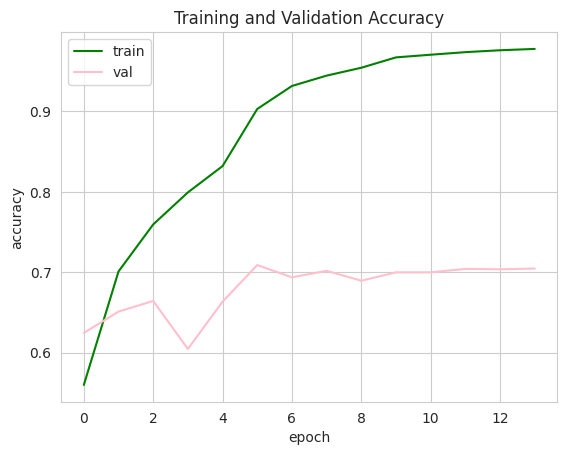

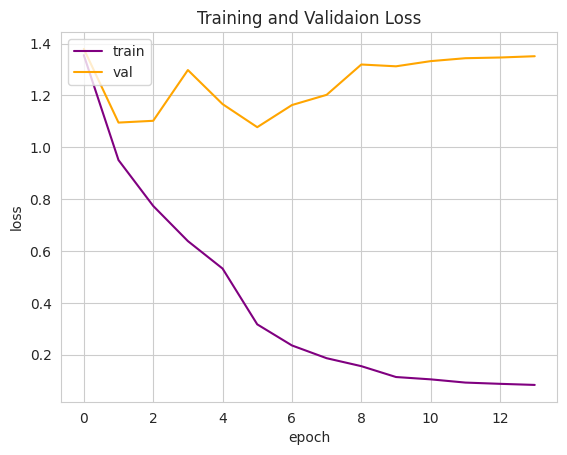

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

sns.set_style("whitegrid")
plt.plot(epochs, acc, 'green')
plt.plot(epochs, val_acc, 'pink')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'purple')
plt.plot(epochs, val_loss, 'orange')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

The highest accuracy value in training reached 97.77% at the 12th epoch, with an accuracy value in validation of 70.41%.

The highest accuracy value in validation reached 70.89% at the 6th epoch with an accuracy value in training of 89.83%.

125/125 - 123s - 986ms/step


               precision    recall  f1-score   support

    apple_pie     0.7754    0.8425    0.8075       381
   cheesecake     0.8963    0.8822    0.8892       382
chicken_curry     0.8799    0.8987    0.8892       375
 french_fries     0.9582    0.9611    0.9596       334
   fried_rice     0.9125    0.9371    0.9247       334
    hamburger     0.9141    0.9016    0.9078       366
      hot_dog     0.9091    0.9016    0.9053       366
    ice_cream     0.9550    0.8534    0.9014       348
     omelette     0.8052    0.8171    0.8111       339
        pizza     0.9517    0.8957    0.9229       374
        sushi     0.8863    0.9270    0.9062       370

     accuracy                         0.8922      3969
    macro avg     0.8949    0.8926    0.8932      3969
 weighted avg     0.8942    0.8922    0.8926      3969



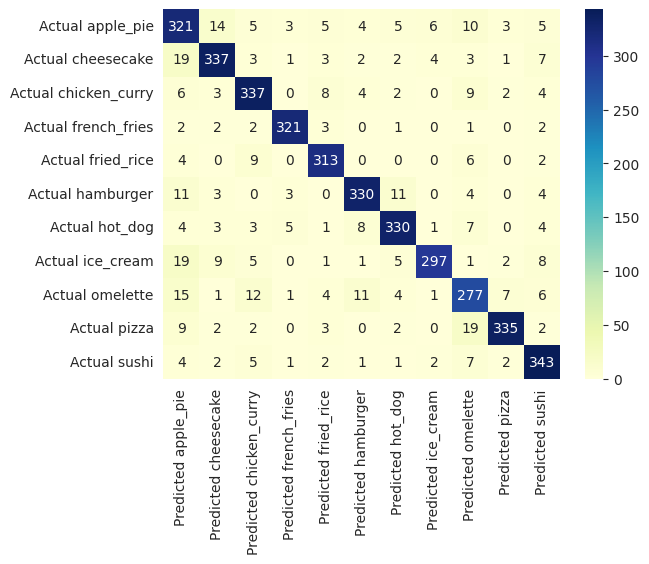

In [58]:
test_gen.reset()

label_names = list(test_gen.class_indices.keys())

preds = model.predict(test_gen,verbose=2)
preds = np.argmax(preds, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_gen.classes, preds, labels=range(len(label_names))),
                  index=[f"Actual {name}" for name in label_names],
                  columns=[f"Predicted {name}" for name in label_names])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_gen.classes, y_pred=preds, target_names =label_names, digits=4))

Obtaining an accuracy value of 89.22% on the test data, which shows a fairly good performance in food image recognition.

Precision, Recall, and F1-Score values show good values in several classes. The highest value in precision, recall, and f1-score is in the french_fries class which has a value of precision 0.9582, recall 0.9611, and f1-score 0.9596.

## Konversi Model

Save model sebagai SavedModel

In [72]:
# Save model in SavedModel format
saved_model_path = '/content/models/saved_model'
tf.saved_model.save(model, saved_model_path)

Save model ke TFJS

In [78]:
# Save model in TFJS format
tfjs.converters.save_keras_model(model, '/content/models/tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


Save model ke TF-Lite

In [77]:
# Convert model to TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save model in tflite format
with open('/content/models/tflite/model.tflite', 'wb') as f:
  f.write(tflite_model)

# Save label.txt
with open('/content/models/tflite/label.txt', 'w') as f:
  for label in label_names:
    f.write(f"{label}\n")

Saved artifact at '/tmp/tmp0d4x4klo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_2167')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  133626806967504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806969616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806968464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806962512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806965392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806966928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806960400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806961552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806961360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133626806970960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13362680

In [80]:
# Path of the folder you want to download
folder_path = '/content/models'

# Create a ZIP file from a folder
shutil.make_archive(folder_path, 'zip', folder_path)

'/content/models.zip'

## Inference (Optional)